In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
df = pd.read_csv('datos_exportados_clean.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [2]:
df['Mes'] = df['Fecha'].dt.month  # Extrae el mes
dato_muestra = df[df['Mes'] == 3]  # Filtra por marzo


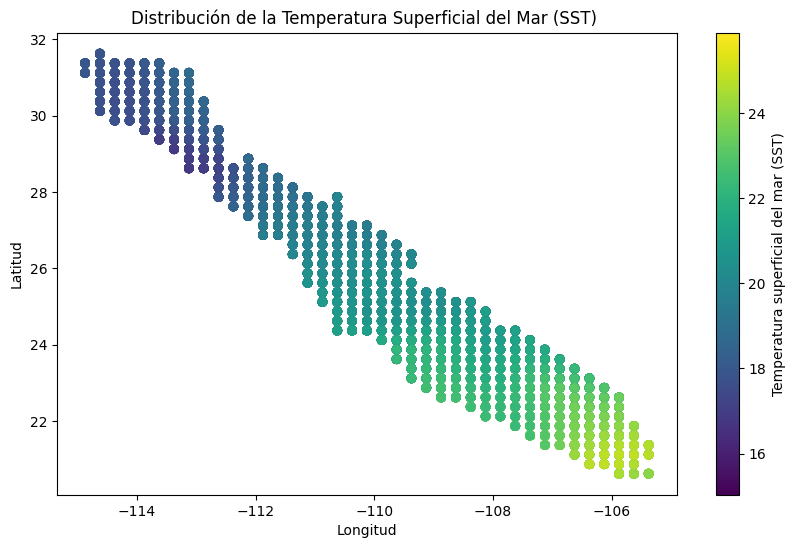

In [3]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(dato_muestra['Longitud'], dato_muestra['Latitud'], c=dato_muestra['SST'], cmap='viridis')
plt.colorbar(sc, label='Temperatura superficial del mar (SST)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución de la Temperatura Superficial del Mar (SST) ')
plt.show()

In [8]:
df.dropna(inplace=True)

In [9]:
# Filtramos el dataset para la latitud y longitud específica
lat = 22.625
lon = -107.125

df_filtered = df[(df['Latitud'] == lat) & (df['Longitud'] == lon)]

In [10]:
df_filtered.to_csv(f'Filtrado_{lat}_{lon}.csv', index=False)

In [11]:
df_filtered = pd.read_csv(f'Filtrado_{lat}_{lon}.csv')

In [12]:
df_filtered

,Fecha,Latitud,Longitud,SST
0,1981-09-01,22.625,-107.125,28.87767
1,1981-10-01,22.625,-107.125,28.74871
2,1981-11-01,22.625,-107.125,26.99600
3,1981-12-01,22.625,-107.125,25.58290
4,1982-01-01,22.625,-107.125,23.63032
...,...,...,...,...
503,2023-08-01,22.625,-107.125,30.16355
504,2023-09-01,22.625,-107.125,30.26433
505,2023-10-01,22.625,-107.125,30.42323
506,2023-11-01,22.625,-107.125,27.76800


In [152]:
df_filtered['Fecha'] = pd.to_datetime(df_filtered['Fecha'])

In [13]:
# Asumiendo que df_filtered ya está preparado y que 'Fecha' es el índice
data = df_filtered.filter(['SST'])
data

,SST
0,28.87767
1,28.74871
2,26.99600
3,25.58290
4,23.63032
...,...
503,30.16355
504,30.26433
505,30.42323
506,27.76800


In [104]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(data['SST'])

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (406,)
Tamaño set de validación: (50,)
Tamaño set de prueba: (52,)


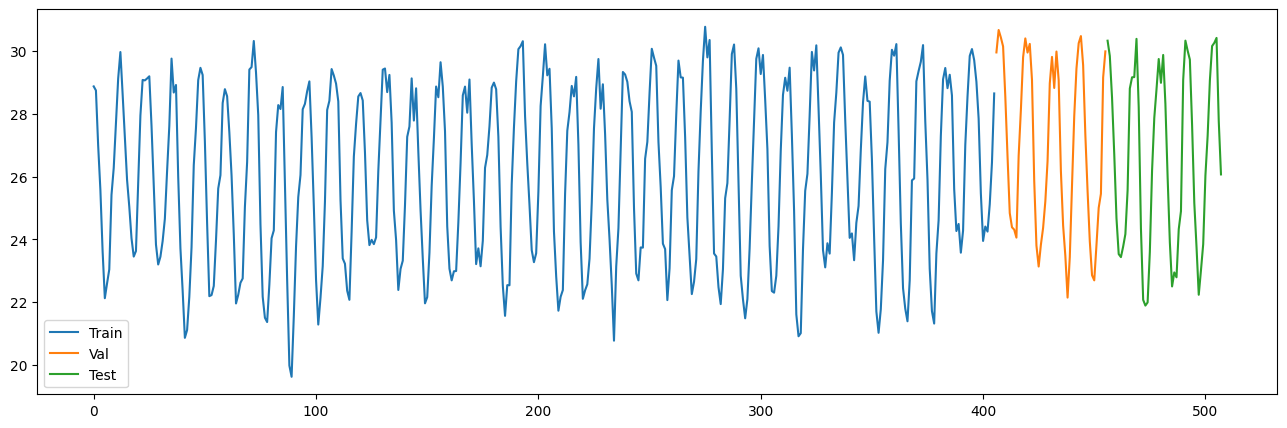

In [105]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
plt.legend();

In [136]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [184]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 36
# Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 6    # Modelo uni-step: ***EL ÚNICO CAMBIO QUE DEBEMOS HACER***

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (364, 36, 1), y_tr: (364, 6, 1)
Set de validación - x_vl: (8, 36, 1), y_vl: (8, 6, 1)
Set de prueba - x_ts: (10, 36, 1), y_ts: (10, 6, 1)


In [185]:
x_tr

array([[[28.87767],
        [28.74871],
        [26.996  ],
        ...,
        [26.17633],
        [27.61452],
        [29.76387]],

       [[28.74871],
        [26.996  ],
        [25.5829 ],
        ...,
        [27.61452],
        [29.76387],
        [28.68167]],

       [[26.996  ],
        [25.5829 ],
        [23.63032],
        ...,
        [29.76387],
        [28.68167],
        [28.92258]],

       ...,

       [[30.22548],
        [27.47333],
        [24.51645],
        ...,
        [29.84774],
        [30.06774],
        [29.71433]],

       [[27.47333],
        [24.51645],
        [22.44806],
        ...,
        [30.06774],
        [29.71433],
        [29.02613]],

       [[24.51645],
        [22.44806],
        [21.79517],
        ...,
        [29.71433],
        [29.02613],
        [27.853  ]]])

In [186]:
x_ts

array([[[30.33433],
        [29.84613],
        [28.52   ],
        [26.71161],
        [24.67387],
        [23.53345],
        [23.43742],
        [23.773  ],
        [24.17097],
        [25.56767],
        [28.81   ],
        [29.16774],
        [29.17433],
        [30.3929 ],
        [28.21033],
        [24.35   ],
        [22.07613],
        [21.89286],
        [21.99323],
        [23.601  ],
        [26.18613],
        [27.87333],
        [28.78387],
        [29.75064],
        [28.99167],
        [29.87968],
        [28.31933],
        [25.98516],
        [23.90806],
        [22.50286],
        [22.94968],
        [22.79367],
        [24.32645],
        [24.90133],
        [29.08323],
        [30.33581]],

       [[29.84613],
        [28.52   ],
        [26.71161],
        [24.67387],
        [23.53345],
        [23.43742],
        [23.773  ],
        [24.17097],
        [25.56767],
        [28.81   ],
        [29.16774],
        [29.17433],
        [30.3929 ],
        [28.21033]

In [187]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [188]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: 19.62393/22.14742/21.89286
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.5475106712414863/-0.5931560605748176

Min y_tr/y_vl/y_ts sin escalamiento: 19.62393/22.69645/22.2375
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.44906359351647573/-0.5313583430235949

Max x_tr/x_vl/x_ts sin escalamiento: 30.77774/30.67581/30.3929
Max x_tr/x_vl/x_ts con escalamiento: 1.0/0.9817228373085065/0.9309939832218763

Max y_tr/y_vl/y_ts sin escalamiento: 30.77774/30.48167/30.42323
Max y_tr/y_vl/y_ts con escalamiento: 1.0/0.946911414126653/0.9364324836087397


In [165]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def root_mean_squared_error(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred - y_true)))

# Especificaciones del modelo
learning_rate =  0.0007379647600658174  # Especifica tu learning rate aquí
batch_size = 32      # Especifica tu batch size aquí

# Definición del modelo
model = Sequential()
# Capa Conv1D
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_tr_s.shape[1], x_tr_s.shape[2])))
model.add(MaxPooling1D(pool_size=3))
# Capa LSTM
model.add(LSTM(128))
model.add(Dropout(0.3))
# Capa de salida
model.add(Dense(OUTPUT_LENGTH, activation='linear'))  # Ajusta según tu caso específico

# Compilación del modelo
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')  # Puedes cambiar la función de pérdida según sea necesario

# Resumen del modelo
model.summary()

# Entrenamiento del modelo
history = model.fit(x_tr_s, y_tr_s, epochs=250, batch_size=batch_size, validation_data=(x_vl_s, y_vl_s), verbose=2)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 4, 64)             256       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 99201 (387.50 KB)
Trainable params: 99201 (387.50 KB)
Non-trainable params: 0 (0.00 Byte)
________________

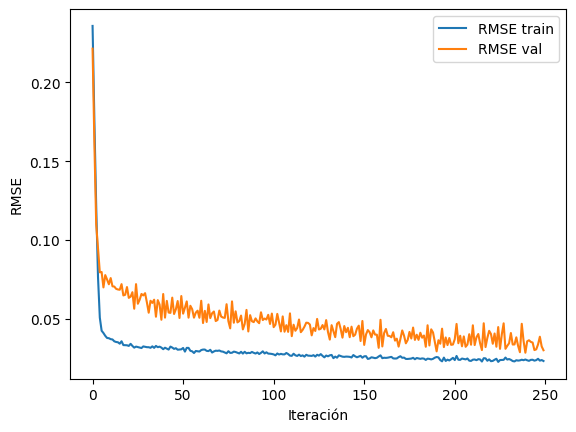

In [166]:
plt.plot(history.history['loss'],label='RMSE train')
plt.plot(history.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [167]:
# Cálculo de rmses para train, val y test
rmse_tr = model.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = model.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = model.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.022
  RMSE val:	 0.030
  RMSE test:	 0.033


In [168]:
y_ts_pred

array([29.503534, 29.164394, 27.713238, 24.928192, 22.917658, 22.231571,
       29.054602, 27.418322, 24.854692, 22.7985  , 22.172167, 22.597034,
       27.836483, 25.1717  , 23.33361 , 22.536127, 22.399311, 23.491598,
       25.311804, 23.41102 , 22.624285, 22.538515, 23.653828, 25.52727 ,
       23.82642 , 22.842953, 22.854963, 23.910624, 25.657406, 27.22063 ,
       23.215664, 22.896667, 23.959265, 25.590094, 26.93231 , 28.494799,
       23.296757, 24.235132, 25.923338, 27.261053, 28.593262, 29.466284,
       24.437551, 26.021814, 27.50863 , 29.042763, 29.93067 , 29.641104,
       26.022427, 27.351223, 28.86625 , 29.889582, 29.771145, 29.240854,
       27.25644 , 28.792503, 29.694809, 29.7001  , 29.328266, 27.94457 ,
       28.943909, 29.87186 , 29.646471, 29.435696, 27.994133, 25.434992,
       29.589878, 29.557457, 29.33774 , 28.227253, 25.734179, 23.68117 ,
       29.66055 , 29.507603, 28.1867  , 25.618174, 23.612476, 22.568743,
       29.979826, 28.38043 , 25.603855, 23.368408, 

In [169]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [170]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, model, scaler)

In [171]:
y_ts_pred

array([23.444904, 23.327227, 25.021935, 26.761744, 27.882038, 28.882847,
       30.297113, 29.244802, 28.551548, 26.672857, 23.739403, 21.57299 ,
       21.996157, 22.815231, 25.136023, 27.439028, 28.996914, 29.52733 ,
       29.41671 , 29.287783, 26.090342, 24.756456, 23.834776, 22.596756,
       22.888481, 23.033062, 25.13014 , 26.656233, 28.22712 , 28.554008,
       30.242876, 30.245857, 30.040136, 27.262672, 23.620493, 23.173637,
       23.043697, 23.173948, 25.551083, 27.48516 , 29.182714, 29.268702,
       29.316826, 29.094402, 27.660769], dtype=float32)

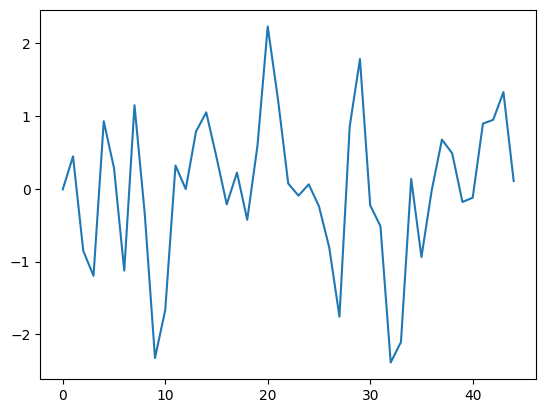

In [172]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [173]:
len(y_ts_pred)

45

In [174]:
ts

456    30.33433
457    29.84613
458    28.52000
459    26.71161
460    24.67387
461    23.53345
462    23.43742
463    23.77300
464    24.17097
465    25.56767
466    28.81000
467    29.16774
468    29.17433
469    30.39290
470    28.21033
471    24.35000
472    22.07613
473    21.89286
474    21.99323
475    23.60100
476    26.18613
477    27.87333
478    28.78387
479    29.75064
480    28.99167
481    29.87968
482    28.31933
483    25.98516
484    23.90806
485    22.50286
486    22.94968
487    22.79367
488    24.32645
489    24.90133
490    29.08323
491    30.33581
492    30.01700
493    29.73290
494    27.65600
495    25.15903
496    23.75677
497    22.23750
498    23.02097
499    23.84967
500    26.03871
501    27.30500
502    29.06064
503    30.16355
504    30.26433
505    30.42323
506    27.76800
507    26.07258
Name: SST, dtype: float64

In [175]:
fechas_predicciones = ts.index[-len(y_ts_pred):]


In [176]:
fechas_predicciones

RangeIndex(start=463, stop=508, step=1)

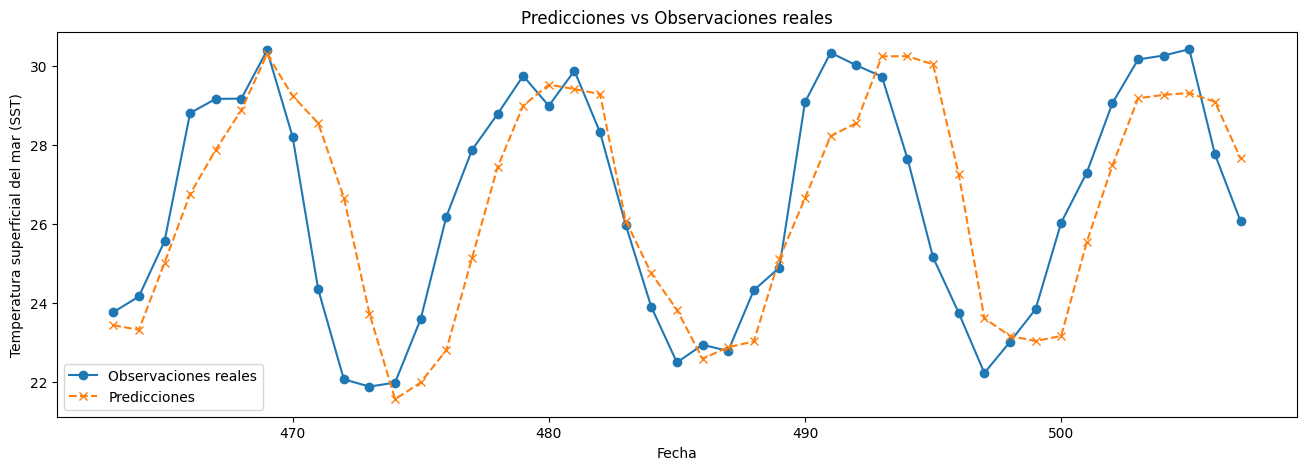

In [177]:

# Creando un DataFrame con las fechas y las predicciones
df_predicciones = pd.DataFrame({'Fecha': fechas_predicciones, 'Predicciones': y_ts_pred})

# Uniendo las predicciones con los datos reales
df_resultados = df_predicciones.set_index('Fecha').join(data['SST'])

# Gráfico de las observaciones reales y las predicciones
plt.figure(figsize=(16, 5))
plt.plot(df_resultados['SST'], label='Observaciones reales', marker='o', linestyle='-')
plt.plot(df_resultados['Predicciones'], label='Predicciones', marker='x', linestyle='--')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Temperatura superficial del mar (SST)')
plt.title('Predicciones vs Observaciones reales')
plt.show()

In [178]:
fechas_predicciones

RangeIndex(start=463, stop=508, step=1)